### CS182 project - Deliver ideas of CGCNN

### General Explanation

The key idea of CGCNN is to represent crystal structure by a crystal graph, which encodes not only
the atomic information but also bonding information between atoms based on the distance. Here we
will let each atomic feature vector as vi, which encodes the property of the atom corresponding to
node i. The edge feature vector is represented as u(i,j)k, which encodes k-th bond connecting atom
i, j. Note that there can be several bonds between atoms, which originate from the periodic nature of
crystals. <br />
Obviously, there are many ways to encode atomic and bond data. For the sake of simplicity, we will
follow the methods used in the CGCNN paper, which used a pre-defined encoding vector to change
atoms into vectors. These vectors have 92 dimensions, and for 100 atoms in the periodic table, they
have different encodings which consist of 0 and 1. For the edge feature vectors, there also can be
many ways to encode bond information; bond length, angle, and covalency. However, we will only
use bond-length information between nearest neighbors, by applying a Gaussian kernel to change
it to encoding vectors. One can follow the homework notebook on how this embedding is done to
NaCl(salt) Crystal.

### Embedding Crystal Graph

In [1]:
# Note: Need pymatgen

In [2]:
import os
import sys
import csv
import json
import torch
import torch.nn as nn
import random
import warnings
warnings.filterwarnings('ignore')
import functools
import numpy as np

from pymatgen.core.structure import Structure
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

from data_utils import CIFData
from data_utils import AtomCustomJSONInitializer
from data_utils import AtomInitializer
from data_utils import GaussianDistance

In [3]:
# Let's convert salt (NaCl) to crystal graph.
# You can use print method to see the lattice and position of Na, Cl
# Atoms in the cell.
nacl = Structure.from_file('hw_data/cifs/1000041.cif')
print(nacl)

Full Formula (Na4 Cl4)
Reduced Formula: NaCl
abc   :   5.620000   5.620000   5.620000
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Na+   0    0    0
  1  Na+   0    0.5  0.5
  2  Na+   0.5  0    0.5
  3  Na+   0.5  0.5  0
  4  Cl-   0.5  0.5  0.5
  5  Cl-   0.5  0    0
  6  Cl-   0    0.5  0
  7  Cl-   0    0    0.5


In [4]:
# add visualization of the structure using the CIF file 

In [5]:
# First we will convert atoms to atomistic features using
# pre-difined atom embedding.
# atom_init.json is containing vector embedding of atoms,
# Where key (1, 2, 3, ..., 100) represent atomic number
# and values are embedding vectors.
# You can try different atom embedding too.

# Load embedding file.
element_embedding_file = 'hw_data/atom_init.json'
with open(element_embedding_file) as f:
    elem_embedding = json.load(f)
elem_embedding = {int(key): value for key, value
                  in elem_embedding.items()}

# Encode crsytal data to atomistic features.
# Atom_feature shd have shape of (# of atoms, len(embedding vector))
atom_fea = np.vstack([elem_embedding[nacl[i].specie.number]
                      for i in range(len(nacl))])
atom_fea = torch.Tensor(atom_fea)

assert atom_fea.shape == (8,92)

In [6]:
# Next, we will get neighbor information from each atoms in the cell.
# We will get help from pymatgen package.
# get_all_neighbor function of structure object returns atoms within
# the input radius. Note that here len(all_nbrs) is 8 since there are
# 8 atoms (4 Na+, 4 Cl-) in the cell. Each list contain the neighbor
# atom information considering periodicity.
# We will use 12 nearest neighbors after sorting with distance.

all_nbrs = nacl.get_all_neighbors(r = 8, include_index=True)
all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]

assert len(all_nbrs) == 8

nbr_fea_idx, nbr_fea = [], []
for nbr in all_nbrs:
    # Note: x[1] returns distance to neighbors.
    # Note: x[2] returns index of original structure object
    nbr_fea_idx.append(list(map(lambda x: x[2],
                                nbr[:12])))
    nbr_fea.append(list(map(lambda x: x[1],
                            nbr[:12])))

# nbr_fea_idx contain information of nearest neighbor atoms 
# from ith row (ith atom in the cell)
# For example, 0th atom (Na+ (0.0000, 0.0000, 0.0000)) is neighbored
# with 5th, 6th, 7th, etc...
# nbr_fea contain information of nearest neighbot distance.
nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
nbr_fea_idx = torch.LongTensor(nbr_fea_idx)

nbr_fea_idx_standard = torch.LongTensor([[5, 6, 7, 7, 6, 5, 2, 1, 2, 1, 3, 3],
                                         [4, 7, 6, 7, 6, 4, 2, 0, 3, 2, 3, 3],
                                         [4, 7, 5, 7, 5, 4, 0, 3, 1, 3, 3, 1],
                                         [4, 6, 5, 6, 5, 4, 2, 1, 1, 2, 0, 0],
                                         [3, 1, 2, 3, 2, 1, 6, 5, 6, 5, 7, 7],
                                         [2, 3, 0, 3, 0, 2, 4, 4, 6, 6, 4, 7],
                                         [1, 3, 0, 3, 0, 1, 4, 4, 5, 5, 5, 4],
                                         [2, 1, 0, 2, 1, 0, 4, 5, 5, 4, 6, 6]])

assert torch.equal(nbr_fea_idx, nbr_fea_idx_standard)

In [7]:
# Now we have two features, atomic feature and neighbor feature.
# Note that neighbor feature is discontionous information with respect to the distanc.
# Therefore we will expand neighbor feature using Gaussian Kernel (or Gaussian filter)
# https://en.wikipedia.org/wiki/Gaussian_filter
dmin = 0
dmax = 12
step = 0.2
var = step
filter_step = np.arange(dmin, dmax+step, step)

def expand(distances):
    # Ask student to do this
    return np.exp(-(distances[..., np.newaxis] - filter_step)**2 / var**2)

nbr_fea_gaussian = expand(nbr_fea)

In [9]:
gdf = GaussianDistance(dmin=0, dmax=12, step=0.2)
nbr_fea = gdf.expand(nbr_fea)

In [ ]:
#assert np.array_equal(nbr_fea_gaussian, nbr_fea)

### Build a Model

After building the crystal graph, the convolutional neural network act on top of the graph, and
consecutive fully connected networks and pooling layer are used to predict the property of crystals.
The convolution layer iteratively updates the atom feature vector $v_{i}$ by message passing with
surrounding atoms and bonds with a non-linear graph convolution function:

$ v_{i}^{(t+1)} = Conv(v_{i}^{(t)}, v_{j}^{(t)}, u_{(i,j)_{k}}), (i,j)_{k} \in G $

And then consequetive pooling layer and hidden fully connected layer will generate output of model:

$ v_{c} = Pool(v_{0}^{(0)}, v_{1}^{(0)}, ..., v_{N}^{(0)}, ..., v_{N}^{(R)}) $

Note that we can use any Convolution and Pooling layer if we maintain the permutation invariance. Here we will try two different convolution layer. Try to implement WeightShareConvLayer in the TODO section of model_hw.py. We will offer solution for the ConvLayer. Note that we will do not change pooling layer, and you can use any activation function you use. But try to use sigmoid function here. After you implement WeightShareConvLayer, try to implement CrystalGraphConvNet by filling in the TODO section of model_hw.py. You can find a detailed explanation there. 

1. WeightShareConvLayer; This is a Convolution weight matrix is shared by all neighbors. <br />
$ v_{i}^{(t+1)} = g[(\sum_{j,k}v_{j}^{(t)} \oplus u_{(i,j)_{k}})W_{c}^{(t)}+v_{i}^{(t)}W_{s}^{(t)}+b^{(t)}] $ <br />
Here $W_{c}, W_{s},$ and $b$ are the convolution weight matrix, self-weight matrix, and bias. <br />


2. ConvLayer; This is a Convolution weight matrix is differentiated at all neighbor pairs. <br />
$ v_{i}^{(t+1)} = v_{i}^{(t+1)} + \sum_{j,k}\sigma(z_{(i,j)_{k}}^{(t)}W_{f}^{(t)}+b_{f}^{(t)}) \odot g(z_{(i,j)_{k}}^{(t)}W_{s}^{(t)}+b_{s}^{(t)}) $ <br />
Here $z_{(i,j)_{k}} = v_{i} \oplus v_{j} \oplus u_{(i,j)_{k}}$, $\odot$ denotes element-wise multiplication and $\sigma$ denotes a sigmoid function.

In [10]:
from model import CrystalGraphConvNet
from model_hw import ConvLayer
from model_hw import WeightShareConvLayer

In [12]:
# For testing purpose
data_dir = './cgcnn_data/sample-regression'
test = CIFData(data_dir)
(atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = test[-1]
structures, _, _ = test[-1]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

In [13]:
torch.manual_seed(123)

convlayer_test = ConvLayer(92, 41)
convlayer_test_result = convlayer_test.forward(atom_fea, nbr_fea, nbr_fea_idx)

weightshare_test = WeightShareConvLayer(92, 41)
weightshare_test_result = weightshare_test.forward(atom_fea, nbr_fea, nbr_fea_idx)

assert convlayer_test_result.shape == (8, 92)
assert weightshare_test_result.shape == (8, 92)

In [14]:
# Simple test
# Set seed using manual_seed
# TODO explanation about crystal_atom_idx
crystal_atom_idx = [torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7]).long()]
model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len)
model.forward(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)

tensor([[0.6627]], grad_fn=<AddmmBackward0>)

### Training

In [15]:
from data_utils import collate_pool, get_train_val_test_loader
from train_utils import Normalizer, train, validate, save_checkpoint
from model import CrystalGraphConvNet
from random import sample

In [16]:
torch.manual_seed(123)

# set parameters
data_dir = './hw_data/perovskite_energy'
batch_size = 8
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

# get dataset

dataset = CIFData(data_dir)
collate_fn = collate_pool
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_fn,
    batch_size=batch_size,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    return_test=True)

In [17]:
# normalize target

if len(dataset) < 500:
    warnings.warn('Dataset has less than 500 data points. '
                    'Lower accuracy is expected. ')
    sample_data_list = [dataset[i] for i in range(len(dataset))]
else:
    sample_data_list = [dataset[i] for i in
                        sample(range(len(dataset)), 500)]
_, sample_target, _ = collate_pool(sample_data_list)
normalizer = Normalizer(sample_target)

In [18]:
# build model
structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

# number of hidden atom features in conv layers
atom_fea_len = 64
# number of hidden features after pooling
h_fea_len = 128
# number of conv layers
n_conv = 3
# number of hidden layers after pooling
n_h = 1

model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=atom_fea_len,
                            n_conv=n_conv,
                            h_fea_len=h_fea_len,
                            n_h=n_h, option='WC')

In [19]:
# set hyperparameters
epochs = 15
criterion = nn.MSELoss()
lr = 0.01
momentum = 0.9
weight_decay = 0

optimizer = optim.SGD(model.parameters(), lr,
                              momentum=momentum,
                              weight_decay=weight_decay)

# optimizer = optim.Adam(model.parameters(), lr,
#                         weight_decay=weight_decay)
lr_milestones = [100]
scheduler = MultiStepLR(optimizer, milestones=lr_milestones,
                            gamma=0.1)

In [20]:
running_record = {'train_loss': [], 'train_mae': [],
                    'val_loss': [], 'val_mae': []}

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)
    
    best_mae_error = 1e10
    # train for one epoch
    train_loss, train_mae = train(train_loader, model, criterion, optimizer, epoch, normalizer)

    # evaluate on validation set
    val_loss, val_mae = validate(val_loader, model, criterion, normalizer)

    # append loss and mae to running record. Convert tensor to float if necessary
    running_record['train_loss'].append(train_loss)
    running_record['train_mae'].append(train_mae)
    running_record['val_loss'].append(val_loss)
    running_record['val_mae'].append(val_mae)


    if val_mae != val_mae:
        print('Exit due to NaN')
        sys.exit(1)

    scheduler.step()

    # remember the best mae_eror and save checkpoint
    is_best = val_mae < best_mae_error
    best_mae_error = min(val_mae, best_mae_error)

    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_mae_error': best_mae_error,
        'optimizer': optimizer.state_dict(),
        'normalizer': normalizer.state_dict(),
    }, is_best)


Epoch 0/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.57it/s]


Train: 	Time 0.144	Data 0.133	Loss 0.9599	MAE 54.027


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


Test: 	Time 0.338	Loss 1.1120	MAE 64.662
Epoch 1/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.63it/s]


Train: 	Time 0.141	Data 0.131	Loss 0.6819	MAE 41.494


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]


Test: 	Time 0.375	Loss 0.4664	MAE 41.394
Epoch 2/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.71it/s]


Train: 	Time 0.138	Data 0.127	Loss 0.6887	MAE 41.391


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Test: 	Time 0.345	Loss 0.4198	MAE 33.237
Epoch 3/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.61it/s]


Train: 	Time 0.142	Data 0.132	Loss 0.5862	MAE 37.129


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


Test: 	Time 0.339	Loss 0.5164	MAE 36.747
Epoch 4/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.69it/s]


Train: 	Time 0.138	Data 0.128	Loss 0.6308	MAE 39.472


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Test: 	Time 0.345	Loss 0.4421	MAE 40.472
Epoch 5/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.68it/s]


Train: 	Time 0.139	Data 0.129	Loss 0.5690	MAE 35.908


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Test: 	Time 0.344	Loss 0.5523	MAE 46.014
Epoch 6/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.71it/s]


Train: 	Time 0.138	Data 0.127	Loss 0.5182	MAE 33.538


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Test: 	Time 0.342	Loss 0.4603	MAE 35.692
Epoch 7/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.69it/s]


Train: 	Time 0.139	Data 0.128	Loss 0.5297	MAE 34.210


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Test: 	Time 0.346	Loss 0.4089	MAE 38.011
Epoch 8/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.61it/s]


Train: 	Time 0.142	Data 0.131	Loss 0.5213	MAE 34.800


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Test: 	Time 0.345	Loss 0.4259	MAE 36.960
Epoch 9/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.54it/s]


Train: 	Time 0.146	Data 0.135	Loss 0.5762	MAE 37.981


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Test: 	Time 0.346	Loss 0.4184	MAE 32.345
Epoch 10/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.62it/s]


Train: 	Time 0.142	Data 0.131	Loss 0.5327	MAE 35.167


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.10it/s]


Test: 	Time 0.357	Loss 0.4099	MAE 36.684
Epoch 11/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.62it/s]


Train: 	Time 0.142	Data 0.131	Loss 0.5399	MAE 36.878


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]


Test: 	Time 0.345	Loss 0.6005	MAE 43.514
Epoch 12/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.59it/s]


Train: 	Time 0.143	Data 0.132	Loss 0.5047	MAE 33.528


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.06it/s]


Test: 	Time 0.385	Loss 0.4275	MAE 39.307
Epoch 13/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:15<00:00,  4.42it/s]


Train: 	Time 0.152	Data 0.141	Loss 0.4739	MAE 34.857


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


Test: 	Time 0.340	Loss 0.3713	MAE 35.174
Epoch 14/14
----------


100%|██████████████████████████████████████████████████████| 67/67 [00:14<00:00,  4.55it/s]


Train: 	Time 0.145	Data 0.134	Loss 0.4415	MAE 31.781


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.11it/s]

Test: 	Time 0.348	Loss 0.4712	MAE 33.399


In [21]:
# test best model
print('---------Evaluate Model on Test Set---------------')
best_checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])
_, l=validate(test_loader, model, criterion, normalizer, test=True)

---------Evaluate Model on Test Set---------------


100%|████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

Test: 	Time 0.379	Loss 1.7929	MAE 49.296


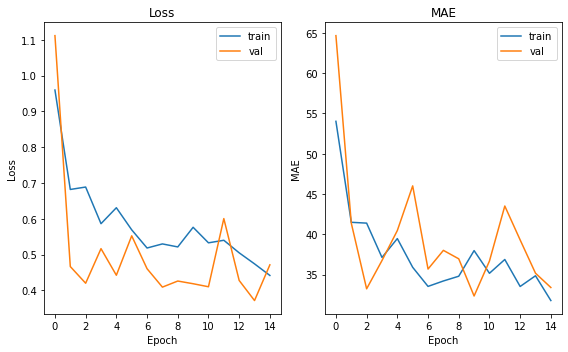

In [22]:
# visualize the training and val loss 
# visualize the training and val mae
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].plot(running_record['train_loss'], label='train')
ax[0].plot(running_record['val_loss'], label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Loss')
# set x axis to be integer
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1].plot(running_record['train_mae'], label='train')
ax[1].plot(running_record['val_mae'], label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
ax[1].set_title('MAE')
# set x axis to be integer
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()